In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import math

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, StratifiedKFold, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix, ConfusionMatrixDisplay, RocCurveDisplay, PrecisionRecallDisplay
from sklearn.inspection import PartialDependenceDisplay

from xgboost import XGBClassifier

from scipy.stats import randint, uniform

from imblearn.over_sampling import SMOTE

from textblob import TextBlob
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

# Exploratory Data Analysis and Feature Engineering

In [2]:
df = pd.read_csv("data/SpotifyFeatures.csv")

In [3]:
df.head()

,genre,artist_name,track_name,track_id,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence
0,Movie,Henri Salvador,C'est beau de faire un Show,0BRjO6ga9RKCKjfDqeFgWV,0,0.611,0.389,99373,0.910,0.000,C#,0.3460,-1.828,Major,0.0525,166.969,4/4,0.814
1,Movie,Martin & les fées,Perdu d'avance (par Gad Elmaleh),0BjC1NfoEOOusryehmNudP,1,0.246,0.590,137373,0.737,0.000,F#,0.1510,-5.559,Minor,0.0868,174.003,4/4,0.816
2,Movie,Joseph Williams,Don't Let Me Be Lonely Tonight,0CoSDzoNIKCRs124s9uTVy,3,0.952,0.663,170267,0.131,0.000,C,0.1030,-13.879,Minor,0.0362,99.488,5/4,0.368
3,Movie,Henri Salvador,Dis-moi Monsieur Gordon Cooper,0Gc6TVm52BwZD07Ki6tIvf,0,0.703,0.240,152427,0.326,0.000,C#,0.0985,-12.178,Major,0.0395,171.758,4/4,0.227
4,Movie,Fabien Nataf,Ouverture,0IuslXpMROHdEPvSl1fTQK,4,0.950,0.331,82625,0.225,0.123,F,0.2020,-21.150,Major,0.0456,140.576,4/4,0.390


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 232725 entries, 0 to 232724
Data columns (total 18 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   genre             232725 non-null  object 
 1   artist_name       232725 non-null  object 
 2   track_name        232724 non-null  object 
 3   track_id          232725 non-null  object 
 4   popularity        232725 non-null  int64  
 5   acousticness      232725 non-null  float64
 6   danceability      232725 non-null  float64
 7   duration_ms       232725 non-null  int64  
 8   energy            232725 non-null  float64
 9   instrumentalness  232725 non-null  float64
 10  key               232725 non-null  object 
 11  liveness          232725 non-null  float64
 12  loudness          232725 non-null  float64
 13  mode              232725 non-null  object 
 14  speechiness       232725 non-null  float64
 15  tempo             232725 non-null  float64
 16  time_signature    23

In [5]:
df.describe(include='object')

,genre,artist_name,track_name,track_id,key,mode,time_signature
count,232725,232725,232724,232725,232725,232725,232725
unique,27,14564,148614,176774,12,2,5
top,Comedy,Giuseppe Verdi,Home,0UE0RhnRaEYsiYgXpyLoZc,C,Major,4/4
freq,9681,1394,100,8,27583,151744,200760


In [6]:
df.describe()

,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence
count,232725.000000,232725.000000,232725.000000,2.327250e+05,232725.000000,232725.000000,232725.000000,232725.000000,232725.000000,232725.000000,232725.000000
mean,41.127502,0.368560,0.554364,2.351223e+05,0.570958,0.148301,0.215009,-9.569885,0.120765,117.666585,0.454917
std,18.189948,0.354768,0.185608,1.189359e+05,0.263456,0.302768,0.198273,5.998204,0.185518,30.898907,0.260065
min,0.000000,0.000000,0.056900,1.538700e+04,0.000020,0.000000,0.009670,-52.457000,0.022200,30.379000,0.000000
25%,29.000000,0.037600,0.435000,1.828570e+05,0.385000,0.000000,0.097400,-11.771000,0.036700,92.959000,0.237000
50%,43.000000,0.232000,0.571000,2.204270e+05,0.605000,0.000044,0.128000,-7.762000,0.050100,115.778000,0.444000
75%,55.000000,0.722000,0.692000,2.657680e+05,0.787000,0.035800,0.264000,-5.501000,0.105000,139.054000,0.660000
max,100.000000,0.996000,0.989000,5.552917e+06,0.999000,0.999000,1.000000,3.744000,0.967000,242.903000,1.000000


In [7]:
#two different strings for the Childrens music genre
df['genre'].unique()

array(['Movie', 'R&B', 'A Capella', 'Alternative', 'Country', 'Dance',
       'Electronic', 'Anime', 'Folk', 'Blues', 'Opera', 'Hip-Hop',
       "Children's Music", 'Children’s Music', 'Rap', 'Indie',
       'Classical', 'Pop', 'Reggae', 'Reggaeton', 'Jazz', 'Rock', 'Ska',
       'Comedy', 'Soul', 'Soundtrack', 'World'], dtype=object)

In [8]:
cat_a = df[df['genre'] == "Children's Music"]
cat_b = df[df['genre'] == 'Children’s Music']
set(cat_a['track_id']).intersection(set(cat_b['track_id']))

set()

In [9]:
df['genre'] = df['genre'].replace('Children’s Music', "Children's Music")
df['genre'].unique()

array(['Movie', 'R&B', 'A Capella', 'Alternative', 'Country', 'Dance',
       'Electronic', 'Anime', 'Folk', 'Blues', 'Opera', 'Hip-Hop',
       "Children's Music", 'Rap', 'Indie', 'Classical', 'Pop', 'Reggae',
       'Reggaeton', 'Jazz', 'Rock', 'Ska', 'Comedy', 'Soul', 'Soundtrack',
       'World'], dtype=object)

In [10]:
df.isna().sum()

genre               0
artist_name         0
track_name          1
track_id            0
popularity          0
acousticness        0
danceability        0
duration_ms         0
energy              0
instrumentalness    0
key                 0
liveness            0
loudness            0
mode                0
speechiness         0
tempo               0
time_signature      0
valence             0
dtype: int64

In [11]:
df[df['track_name'].isna()]

,genre,artist_name,track_name,track_id,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence
208285,World,Elevation Worship,NaN,7BGQCe62A58Q5ZgpQFX93t,44,0.019,0.287,350027,0.446,0.0,F,0.1,-7.214,Major,0.0317,138.727,4/4,0.0387


In [12]:
df = df.dropna()

In [13]:
#check if any entry is an empty string
df[df.apply(lambda x: x.astype(str).str.strip().eq('')).any(axis=1)].shape

(0, 18)

In [14]:
df['merge_key'] = df[['track_name', 'artist_name']].agg(lambda x: '|'.join(x.str.lower().str.strip()), axis=1)
lookup_keys = set(df['merge_key'])

In [15]:
lyrics_path = "data/song_lyrics.csv"
chunksize = 100000
matched_chunks = []

for i, chunk in enumerate(pd.read_csv(lyrics_path, chunksize=chunksize, low_memory=False)):
    chunk['track_name'] = chunk['title'].astype(str).str.lower().str.strip()
    chunk['artist_name'] = chunk['artist'].astype(str).str.lower().str.strip()

    chunk['merge_key'] = chunk['track_name'] + '|' + chunk['artist_name']

    matched = chunk[chunk['merge_key'].isin(lookup_keys)]

    if not matched.empty:
        matched_chunks.append(matched)
        print(f"Found {len(matched)} matches in chunk {i+1}")


Found 4028 matches in chunk 1
Found 3948 matches in chunk 2
Found 3468 matches in chunk 3
Found 3405 matches in chunk 4
Found 2545 matches in chunk 5
Found 1742 matches in chunk 6
Found 1495 matches in chunk 7
Found 1396 matches in chunk 8
Found 1393 matches in chunk 9
Found 1373 matches in chunk 10
Found 1394 matches in chunk 11
Found 1342 matches in chunk 12
Found 1420 matches in chunk 13
Found 1307 matches in chunk 14
Found 1741 matches in chunk 15
Found 2118 matches in chunk 16
Found 2132 matches in chunk 17
Found 2333 matches in chunk 18
Found 2767 matches in chunk 19
Found 2196 matches in chunk 20
Found 2450 matches in chunk 21
Found 2447 matches in chunk 22
Found 1855 matches in chunk 23
Found 2026 matches in chunk 24
Found 1884 matches in chunk 25
Found 1866 matches in chunk 26
Found 1883 matches in chunk 27
Found 1622 matches in chunk 28
Found 1695 matches in chunk 29
Found 618 matches in chunk 30
Found 446 matches in chunk 31
Found 208 matches in chunk 32
Found 153 matches in

In [16]:
lyrics_matched_df = pd.concat(matched_chunks, ignore_index=True)

In [17]:
print(f"Total matched lyrics: {len(lyrics_matched_df)}")

Total matched lyrics: 64111


In [18]:
lyrics_matched_df.head()

,title,tag,artist,year,views,features,lyrics,id,language_cld3,language_ft,language,track_name,artist_name,merge_key
0,Money On My Mind,rap,Lil Wayne,2005,128927,{},"[Intro]\nYeah\nMoney on my mind, money on my m...",12,en,en,en,money on my mind,lil wayne,money on my mind|lil wayne
1,98 Freestyle,rap,Big L,2000,297788,{},"[Verse 1]\nYo, fuck all the glamours and glitz...",16,en,en,en,98 freestyle,big l,98 freestyle|big l
2,Mr. Carter,rap,Lil Wayne,2008,542488,{JAY-Z},[Produced by Infamous and Drew Correa]\n\n[Int...,126,en,en,en,mr. carter,lil wayne,mr. carter|lil wayne
3,C.R.E.A.M.,rap,Wu-Tang Clan,1994,1984638,{},[Produced by RZA]\n\n[Intro: Raekwon & Method ...,28,en,en,en,c.r.e.a.m.,wu-tang clan,c.r.e.a.m.|wu-tang clan
4,Warning,rap,The Notorious B.I.G.,1994,617475,{},[Produced by Easy Mo Bee]\n\n[Verse 1: The Not...,29,en,en,en,warning,the notorious b.i.g.,warning|the notorious b.i.g.


In [19]:
df = pd.merge(
    df,
    lyrics_matched_df[['merge_key', 'lyrics']],
    on='merge_key',
    how='inner'
)
df = df.drop(['merge_key'], axis=1)

In [20]:
df.head()

,genre,artist_name,track_name,track_id,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence,lyrics
0,Movie,Henri Salvador,Le petit souper aux chandelles,0Mf1jKa8eNAf1a4PwTbizj,0,0.749,0.578,160627,0.0948,0.000000,C#,0.107,-14.970,Major,0.1430,87.479,4/4,0.358,Il y avait du monde la veille\nEt il restait d...
1,Movie,Henri Salvador,Quand je monte chez toi,15nBPcHoH2fZmRiFd2ZhMh,5,0.706,0.526,181441,0.2980,0.000000,F,0.143,-7.287,Major,0.0621,156.350,4/4,0.396,"Quand je monte, je monte, je monte, je monte c..."
2,Movie,Henri Salvador,Le Fêtard,16hVzfu0IJZmP3Bj4x1BB1,0,0.159,0.636,152840,0.5940,0.000000,G#,0.184,-7.943,Major,0.0840,111.361,4/4,0.669,Écoutez l'histoire affreuse\nL'aventure doulou...
3,Movie,Henri Salvador,Une chanson douce,1J5pa9cW0uCsNrFwag0jDD,2,0.716,0.835,142813,0.3840,0.000008,G#,0.265,-15.629,Major,0.1270,126.892,4/4,0.971,Une chanson douce\nQue me chantait ma maman\nE...
4,Movie,Henri Salvador,Cherche la rose,3j2I9sLlBQu8pMPDvw6Mhn,3,0.619,0.242,208733,0.3120,0.000001,C#,0.109,-10.820,Major,0.0288,80.977,4/4,0.146,Dans le sable du désert\nSur les dunes de la m...


In [21]:
df.isna().sum()

genre               0
artist_name         0
track_name          0
track_id            0
popularity          0
acousticness        0
danceability        0
duration_ms         0
energy              0
instrumentalness    0
key                 0
liveness            0
loudness            0
mode                0
speechiness         0
tempo               0
time_signature      0
valence             0
lyrics              0
dtype: int64

In [22]:
#better for formal text and longer text
df['blob_sentiment'] = df['lyrics'].apply(lambda x: TextBlob(x).sentiment.polarity)

In [23]:
#better for informal text and can capture emotion of brief snippets
analyzer = SentimentIntensityAnalyzer()
df['vader_sentiment'] = df['lyrics'].apply(lambda x: analyzer.polarity_scores(x)['compound'])

In [24]:
#define a hit as something that has a popularity of 70 or greater
df['is_hit'] = (df['popularity'] > 70).astype(int)
df['is_hit'].value_counts()

is_hit
0    95679
1     4442
Name: count, dtype: int64

In [25]:
df['blob_sentiment'].corr(df['vader_sentiment'])

np.float64(0.4120898841830529)

In [26]:
#songs can be in multiple different genres at once and could have different popularity because of it
df[df.duplicated(subset=['track_id'], keep=False)].sort_values(by='track_id').tail(6)

,genre,artist_name,track_name,track_id,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,...,loudness,mode,speechiness,tempo,time_signature,valence,lyrics,blob_sentiment,vader_sentiment,is_hit
47411,Children's Music,Bay Faction,Beach Book,7zy2ezQByCeFcaDtsxt77o,44,0.063200,0.537,189750,0.474,0.002590,...,-7.44,Minor,0.050,147.310,4/4,0.474,So I may be drunk\nAnd I may have a cold\nBut ...,-0.236389,0.9652,0
6657,Alternative,Bay Faction,Beach Book,7zy2ezQByCeFcaDtsxt77o,40,0.063200,0.537,189750,0.474,0.002590,...,-7.44,Minor,0.050,147.310,4/4,0.474,So I may be drunk\nAnd I may have a cold\nBut ...,-0.236389,0.9652,0
45067,Children's Music,Five Finger Death Punch,Dot Your Eyes,7zyJ2g9o0nVOBbDavVveCl,54,0.000508,0.488,195091,0.994,0.000000,...,-3.96,Minor,0.119,74.011,4/4,0.376,[Intro]\nBring it!\n\n[Verse 1]\nMy life is pe...,-0.010208,-0.9369,0
2924,Alternative,Five Finger Death Punch,Dot Your Eyes,7zyJ2g9o0nVOBbDavVveCl,50,0.000508,0.488,195091,0.994,0.000000,...,-3.96,Minor,0.119,74.011,4/4,0.376,[Intro]\nBring it!\n\n[Verse 1]\nMy life is pe...,-0.010208,-0.9369,0
66389,Indie,Moonstar88,Migraine,7zzZmpw8L66ZPjH1M6qmOs,67,0.217000,0.664,267960,0.537,0.000003,...,-6.00,Major,0.029,115.049,4/4,0.221,"[Verse 1]\nOo nga pala, hindi nga pala tayo\nH...",0.000000,0.0000,0
47336,Children's Music,Moonstar88,Migraine,7zzZmpw8L66ZPjH1M6qmOs,67,0.217000,0.664,267960,0.537,0.000003,...,-6.00,Major,0.029,115.049,4/4,0.221,"[Verse 1]\nOo nga pala, hindi nga pala tayo\nH...",0.000000,0.0000,0


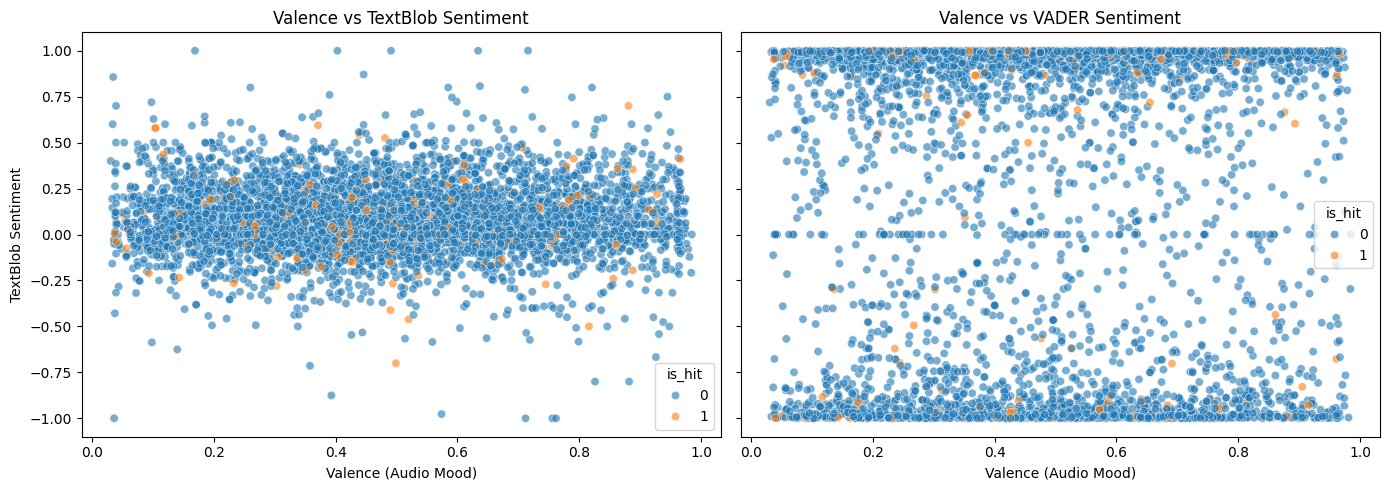

In [27]:
#How does valence(emotional positivity or negativity) correspond to the text sentiment?
sample = df.sample(min(5000, len(df)), random_state=42)

fig, axes = plt.subplots(1, 2, figsize=(14, 5), sharey=True)

sns.scatterplot(
    data=sample, x='valence', y='blob_sentiment', hue='is_hit', alpha=0.6, ax=axes[0]
)
axes[0].set_title("Valence vs TextBlob Sentiment")
axes[0].set_xlabel("Valence (Audio Mood)")
axes[0].set_ylabel("TextBlob Sentiment")

sns.scatterplot(
    data=sample, x='valence', y='vader_sentiment', hue='is_hit', alpha=0.6, ax=axes[1]
)
axes[1].set_title("Valence vs VADER Sentiment")
axes[1].set_xlabel("Valence (Audio Mood)")
axes[1].set_ylabel("VADER Sentiment")

plt.tight_layout()
plt.show()

In [28]:
numeric_cols = [col for col in df.columns if col not in ['genre','artist_name', 'track_name', 'track_id', 'time_signature', 'lyrics', 'key', 'mode']]

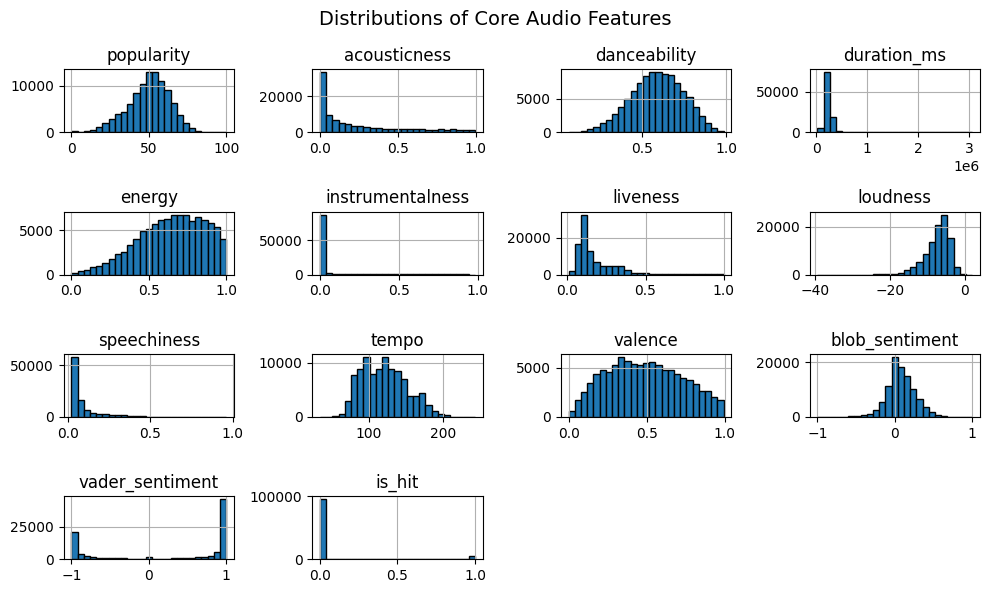

In [29]:
df[numeric_cols].hist(bins=25, figsize=(10,6), edgecolor='black')
plt.suptitle("Distributions of Core Audio Features", fontsize=14)
plt.tight_layout()
plt.show()

In [30]:
df[numeric_cols].skew()

popularity         -0.446105
acousticness        1.106665
danceability       -0.199815
duration_ms         3.167931
energy             -0.426799
instrumentalness    3.846418
liveness            2.246170
loudness           -1.315039
speechiness         3.415557
tempo               0.387349
valence             0.133896
blob_sentiment      0.008462
vader_sentiment    -0.566113
is_hit              4.425679
dtype: float64

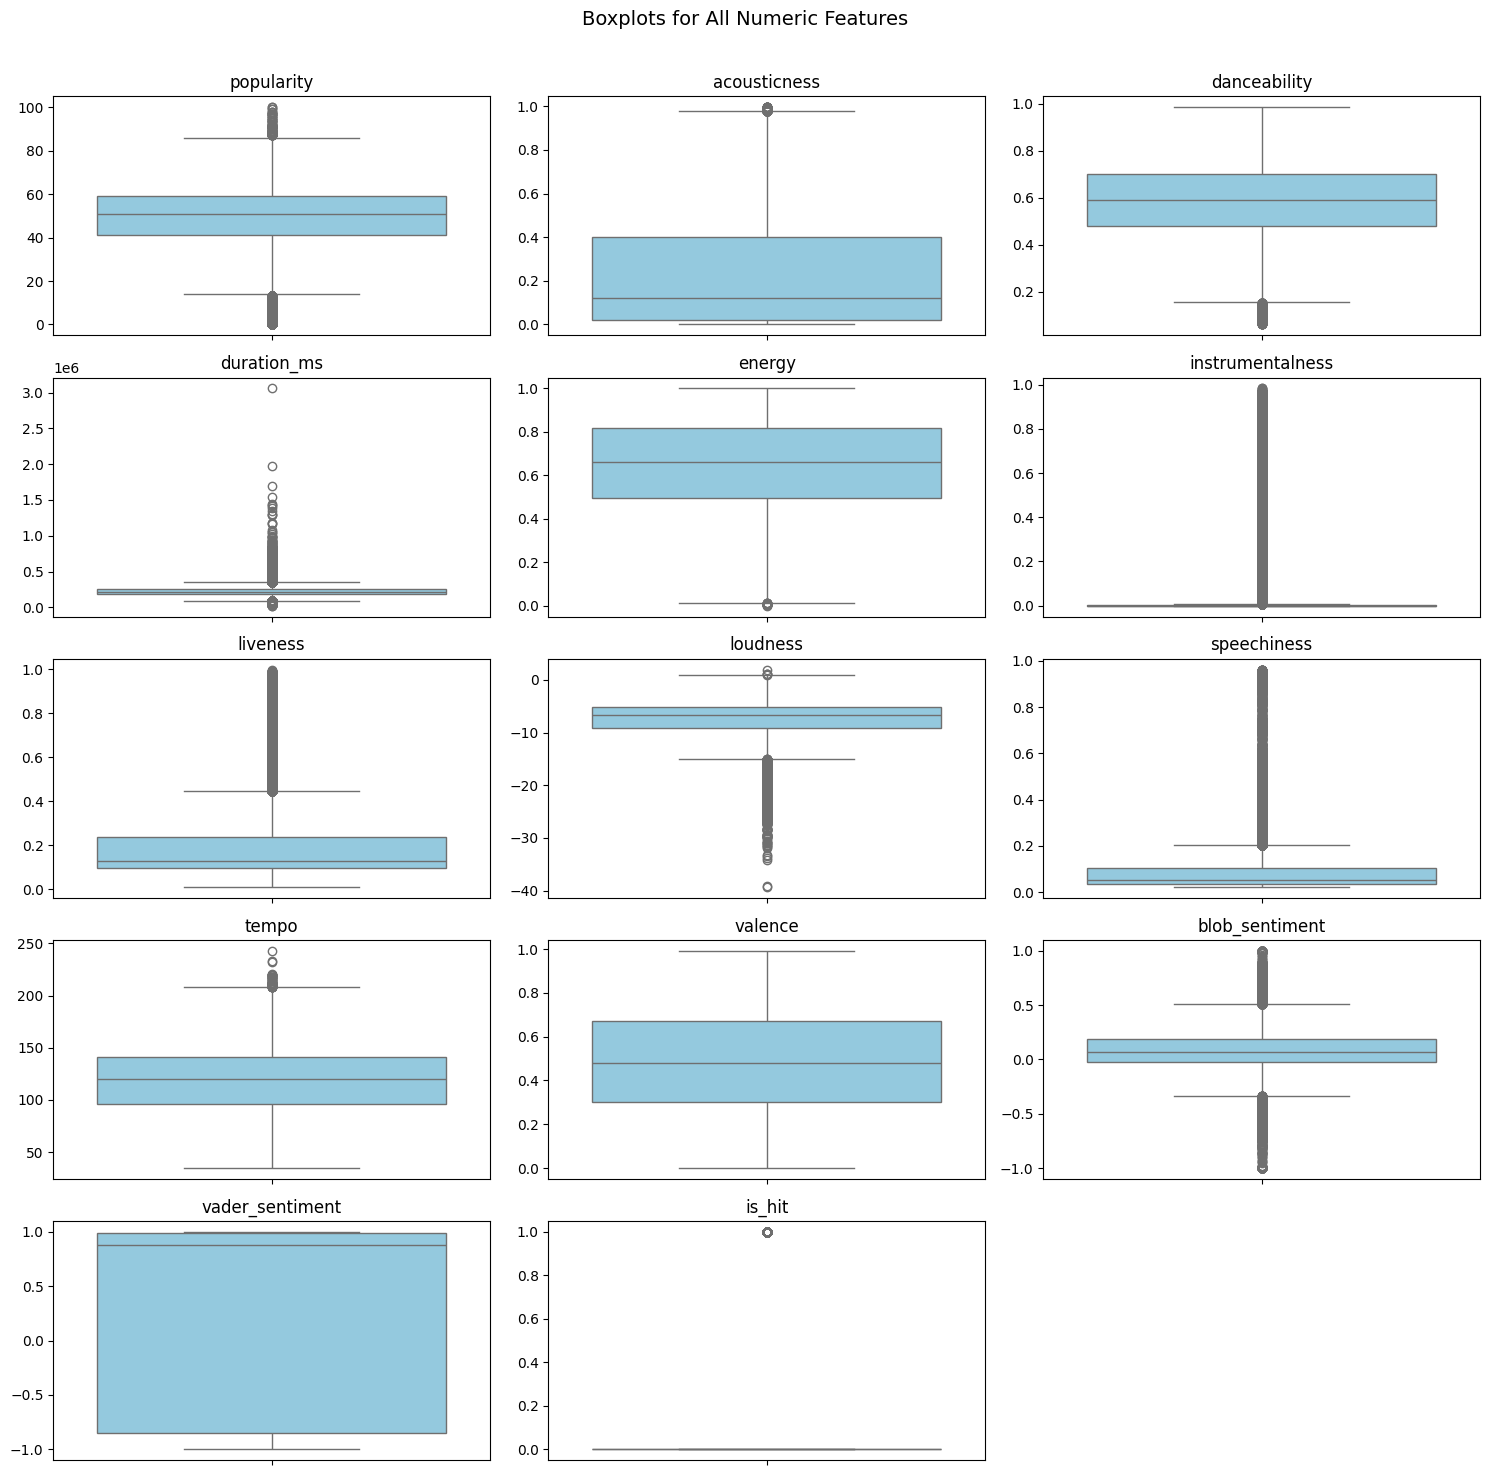

In [31]:
numeric_cols = df.select_dtypes(include=['number']).columns
n_cols = 3  # number of plots per row
n_rows = math.ceil(len(numeric_cols) / n_cols)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, n_rows * 3))
axes = axes.flatten()

for i, col in enumerate(numeric_cols):
    sns.boxplot(y=df[col], ax=axes[i], color='skyblue')
    axes[i].set_title(col)
    axes[i].set_xlabel("")
    axes[i].set_ylabel("")

# Hide empty subplots (if any)
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.suptitle("Boxplots for All Numeric Features", fontsize=14)
plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()

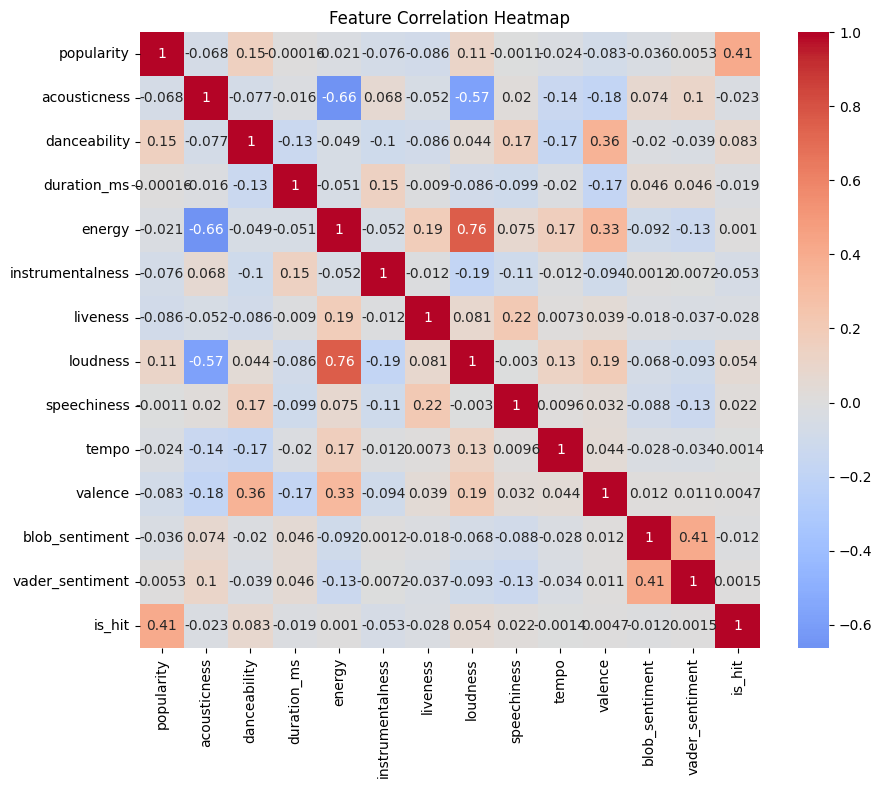

In [32]:
plt.figure(figsize=(10,8))
sns.heatmap(df[numeric_cols].corr(), annot=True, cmap='coolwarm', center=0)
plt.title("Feature Correlation Heatmap")
plt.show()

In [33]:
df = pd.get_dummies(df, columns=['key', 'mode'], prefix=['key', 'mode'])

# Modeling

ROC AUC: 0.947
              precision    recall  f1-score   support

           0       0.99      1.00      0.99     19137
           1       0.95      0.79      0.86       888

    accuracy                           0.99     20025
   macro avg       0.97      0.89      0.93     20025
weighted avg       0.99      0.99      0.99     20025



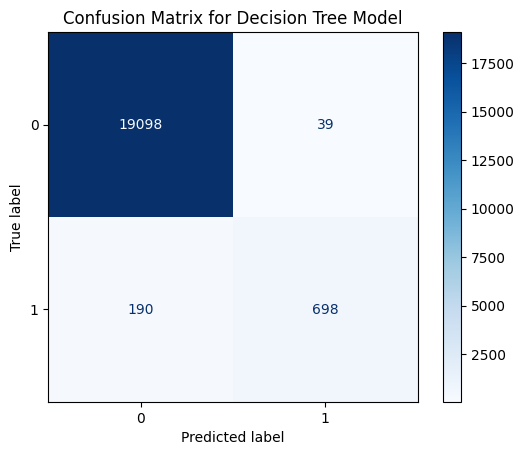

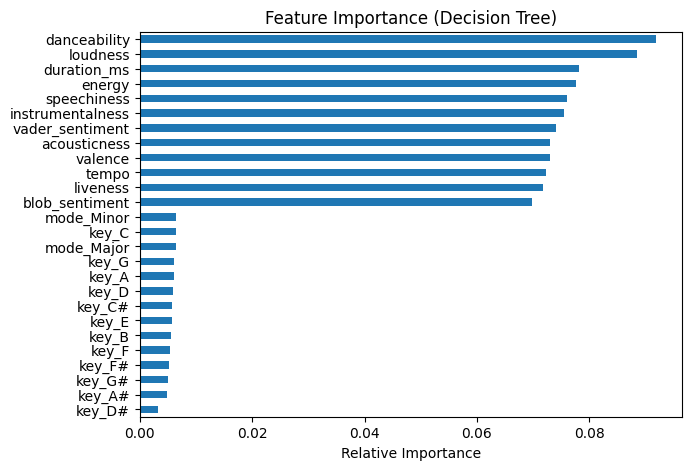

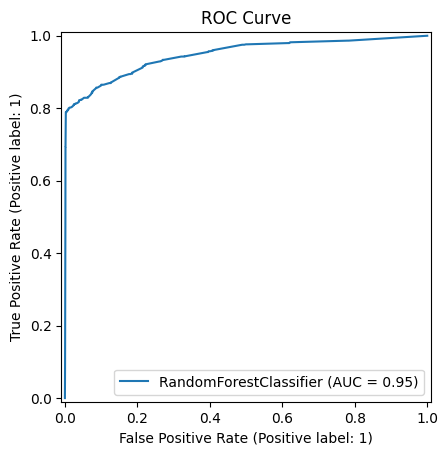

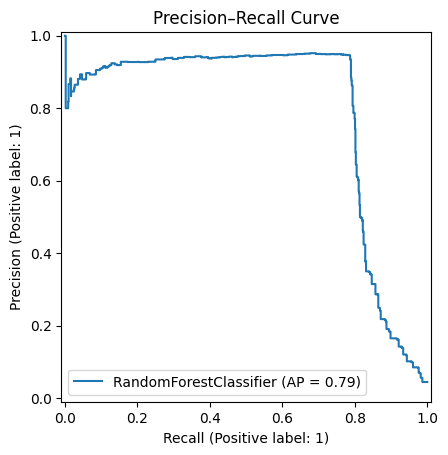

In [34]:
#class balancing for random forest
features = [col for col in df.columns if col not in ['genre','artist_name', 'track_name', 'track_id', 'mode', 'key', 'time_signature', 'is_hit', 'popularity', 'lyrics']]
X = df[features]
y = df['is_hit']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

cb_rf = RandomForestClassifier(n_estimators=200, class_weight='balanced', random_state=42)
cb_rf.fit(X_train, y_train)
y_pred = cb_rf.predict(X_test)
y_proba = cb_rf.predict_proba(X_test)[:, 1]

print("ROC AUC:", round(roc_auc_score(y_test, y_proba), 3))
print(classification_report(y_test, y_pred))

ConfusionMatrixDisplay.from_estimator(cb_rf, X_test, y_test, cmap='Blues')
plt.title("Confusion Matrix for Decision Tree Model")
plt.show()

feature_importance = pd.Series(cb_rf.feature_importances_, index=features)
feature_importance.sort_values().plot(kind='barh', figsize=(7,5))
plt.title("Feature Importance (Decision Tree)")
plt.xlabel("Relative Importance")
plt.show()

RocCurveDisplay.from_estimator(cb_rf, X_test, y_test)
plt.title("ROC Curve")
plt.show()

PrecisionRecallDisplay.from_estimator(cb_rf, X_test, y_test)
plt.title("Precision–Recall Curve")
plt.show()

ROC AUC: 0.955
              precision    recall  f1-score   support

           0       0.99      0.99      0.99     19137
           1       0.80      0.78      0.79       888

    accuracy                           0.98     20025
   macro avg       0.90      0.89      0.89     20025
weighted avg       0.98      0.98      0.98     20025



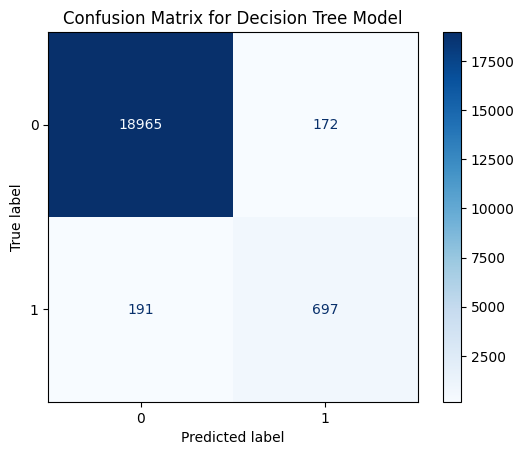

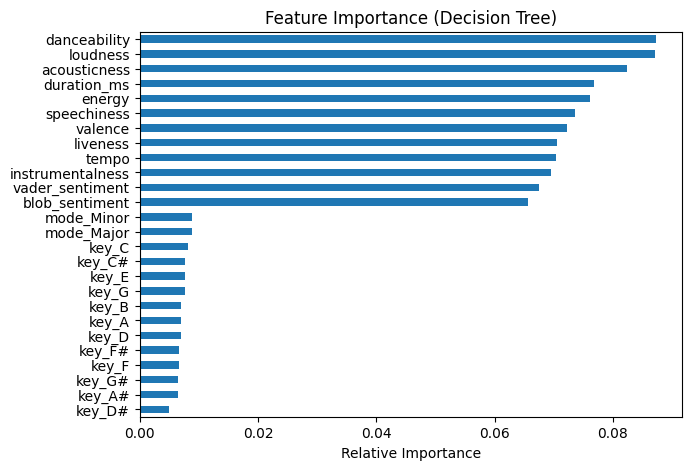

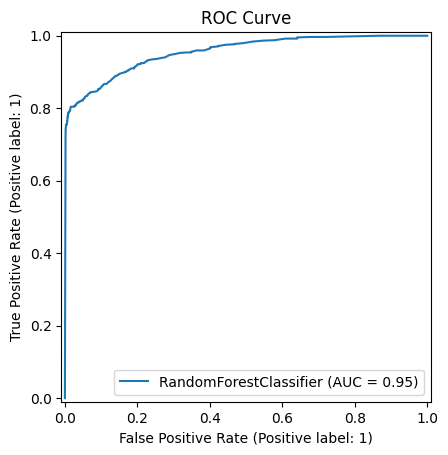

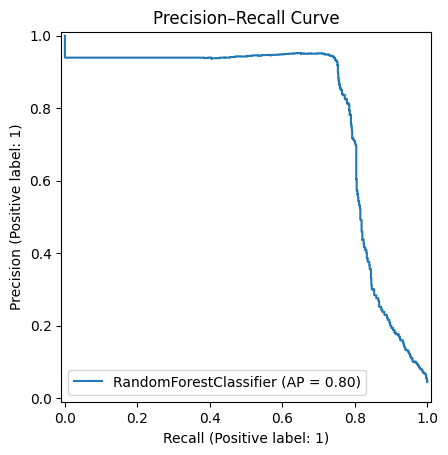

In [36]:
#SMOTE for random forest
features = [col for col in df.columns if col not in ['genre','artist_name', 'track_name', 'track_id', 'time_signature', 'is_hit', 'popularity', 'lyrics']]
X = df[features]
y = df['is_hit']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42, stratify=y)
smote = SMOTE(random_state=42)
X_train, y_train = smote.fit_resample(X_train, y_train)

sm_rf = RandomForestClassifier(n_estimators=200, random_state=42)
sm_rf.fit(X_train, y_train)
y_pred = sm_rf.predict(X_test)
y_proba = sm_rf.predict_proba(X_test)[:, 1]

print("ROC AUC:", round(roc_auc_score(y_test, y_proba), 3))
print(classification_report(y_test, y_pred))

ConfusionMatrixDisplay.from_estimator(sm_rf, X_test, y_test, cmap='Blues')
plt.title("Confusion Matrix for Decision Tree Model")
plt.show()

feature_importance = pd.Series(sm_rf.feature_importances_, index=features)
feature_importance.sort_values().plot(kind='barh', figsize=(7,5))
plt.title("Feature Importance (Decision Tree)")
plt.xlabel("Relative Importance")
plt.show()

RocCurveDisplay.from_estimator(sm_rf, X_test, y_test)
plt.title("ROC Curve")
plt.show()

PrecisionRecallDisplay.from_estimator(sm_rf, X_test, y_test)
plt.title("Precision–Recall Curve")
plt.show()

In [ ]:
features = [col for col in df.columns if col not in ['genre','artist_name', 'track_name', 'track_id', 'mode', 'key', 'time_signature', 'is_hit', 'popularity', 'lyrics']]
X = df[features]
y = df['is_hit']

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.2,, random_state=42, stratify=y)

param_dist = {
    'n_estimators': randint(200, 800),
    'max_depth': randint(5, 25),
    'min_samples_split': randint(2, 20),
    'min_samples_leaf': randint(1, 10),
    'max_features': ['sqrt', 'log2', 0.5, None],
}

rf = RandomForestClassifier(class_weight='balanced', random_state=42)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

search = RandomizedSearchCV(
    rf, param_distributions=param_dist, n_iter=15,
    scoring='average_precision', cv=cv, n_jobs=-1, random_state=42
)
search.fit(X_train, y_train)
best_rf = search.best_estimator_
print("Best parameters:", search.best_params_)

ROC AUC: 0.927
              precision    recall  f1-score   support

           0       0.99      0.99      0.99     19137
           1       0.72      0.80      0.76       888

    accuracy                           0.98     20025
   macro avg       0.85      0.89      0.87     20025
weighted avg       0.98      0.98      0.98     20025



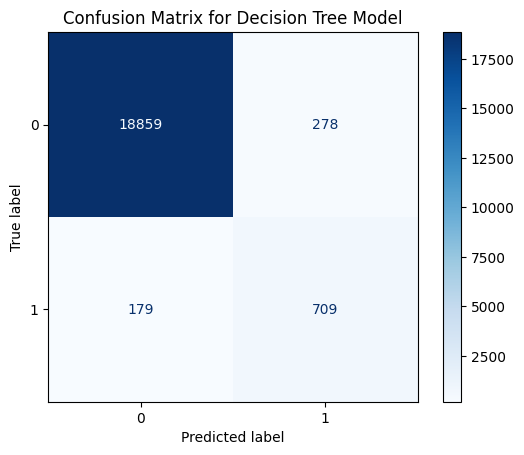

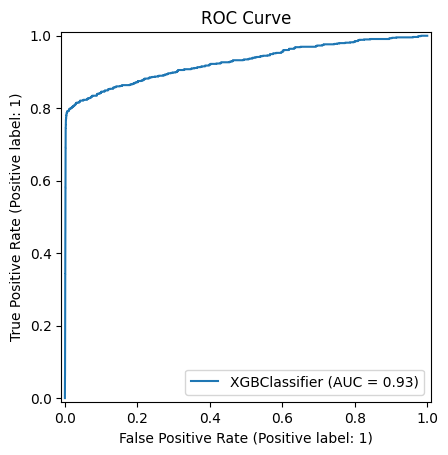

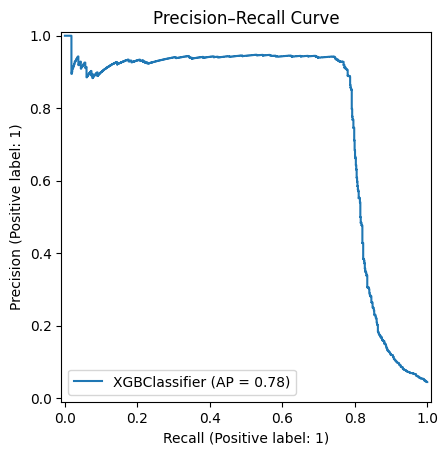

In [35]:
#XGBoost
features = [col for col in df.columns if col not in ['genre','artist_name', 'track_name', 'track_id', 'time_signature', 'is_hit', 'popularity', 'lyrics']]
X = df[features]
y = df['is_hit']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

xgb = XGBClassifier(
    n_estimators=500,
    learning_rate=0.05,
    max_depth=8,
    subsample=0.8,
    colsample_bytree=0.8,
    gamma=0.1,
    reg_lambda=1.0,
    scale_pos_weight=len(y_train[y_train == 0]) / len(y_train[y_train == 1]),
    eval_metric='aucpr',
    random_state=42,
    n_jobs=-1
)
xgb.fit(X_train, y_train)
y_pred = xgb.predict(X_test)
y_proba = xgb.predict_proba(X_test)[:, 1]

print("ROC AUC:", round(roc_auc_score(y_test, y_proba), 3))
print(classification_report(y_test, y_pred))

ConfusionMatrixDisplay.from_estimator(xgb, X_test, y_test, cmap='Blues')
plt.title("Confusion Matrix for Decision Tree Model")
plt.show()

RocCurveDisplay.from_estimator(xgb, X_test, y_test)
plt.title("ROC Curve")
plt.show()

PrecisionRecallDisplay.from_estimator(xgb, X_test, y_test)
plt.title("Precision–Recall Curve")
plt.show()

# Conclusion

**Class-Balanced Random Forest**
- ROC AUC = 0.947 | F1 = 0.86 | Recall = 0.79 | Precision = 0.95
- Strong recall and precision balance; highest F1 overall.
- Handles class imbalance naturally without data resampling.

**SMOTE + Random Forest**
- ROC AUC = 0.955 | F1 = 0.79 | Recall = 0.78 | Precision = 0.80
- Slightly higher ROC AUC but weaker F1 and precision; synthetic samples added noise.

**XGBoost**
- ROC AUC = 0.927 | F1 = 0.76 | Recall = 0.80 | Precision = 0.72
- Good recall but lower precision; overall weaker separation and calibration.

Class-Balanced Random Forest has the best performance.

### Limitations and Future Work
This project was completed on a lightweight CPU-laptop. I will be updating the notebook soon with cross validation and hyperparameter tuning.